In [1]:
import numpy as np
from numpy import genfromtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif,  SelectPercentile
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from random import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
import pandas as pd

02
04
05
06
09
11
12
0.8190129513235362
0.9401657029528823
0.7025837723276315
0.9335365449199602
0.6793515993367855
0.8687767274906167
0.5500065897142958
0.17493791994015526
0.6661345561063189
0.436287485679288
0.7539059914317031
0.5362406993126092
0.7186944544742164
0.22159124541005626
0.2361593064678095
0.6037309875751801
0.6578256703295348
0.5855053118038188
0.7041254072961003
0.9497340255122704
0.00411498649258554
0.8904567417281273
0.6905942749642489
0.24224743767333834
0.14909674697937628


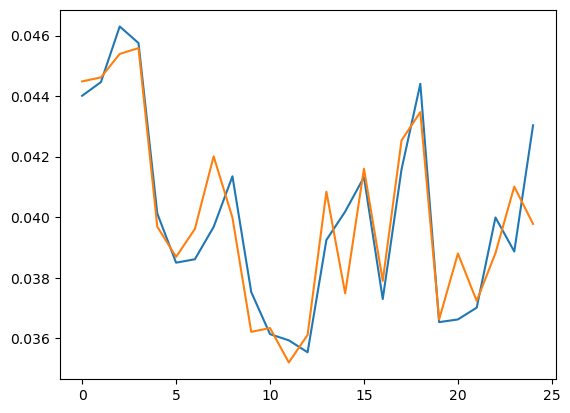

In [9]:

nfolds = 5
niter = 1000
k = 25
sujnum = ['02','04','05','06','09','11','12']

fi =   np.zeros((len(sujnum),k))
fi_sh = np.zeros((len(sujnum),k))

real = []
shuffled = []
m=-1
for num in sujnum:
    m=m+1
    print(num)
    eeg = genfromtxt('/home/nicobruno/flor/Tesis/resultados/S'+num+'_auditivo_evoked_all_marker.csv', skip_header = 1, usecols = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29, 30], delimiter=',')
    labels = genfromtxt('/home/nicobruno/flor/Tesis/vectores/S_'+num+'_auditivo.csv', skip_header = 1, delimiter=',')
    eeg = eeg[:,0:k]
    features = np.zeros((nfolds*niter, k))
    features_sh = np.zeros((nfolds*niter, k))

    kf = KFold(n_splits=nfolds) # validación cruzada (número de folds)
    
    
    all_auc = []
    all_auc_sh = []

    selected = np.zeros((niter*nfolds,k))
    
    
    n=-1
    for i in np.arange(niter):
       
        for train, test in kf.split(eeg):
            n=n+1
            temp = []
            temp_sh= []
            X_train, X_test, y_train, y_test = eeg[train], eeg[test], labels[train], labels[test]
            # ABAJO ESTÁ LA GRILLA DE SELECCION DE PARAMETROS. PROBAR CON DISTINTOS RANGOS Y PASOS ALPHA
            
            
            selector = SelectKBest(k=k)
            selector.fit(X_train, y_train)
            X_train_new = selector.transform(X_train)
            X_test_new = selector.transform(X_test)
            selected[n,:] = selector.get_support()
    
            clf = RandomForestClassifier(n_estimators=100)
            clf.fit(X_train_new,y_train)
            grid_predictions_stack = clf.predict_proba(X_test_new)
            temp.append(roc_auc_score(y_test, grid_predictions_stack[:,1]))
            features[n,:] = clf.feature_importances_
            y_train_sh = y_train.copy()  
            shuffle(y_train_sh)
    
            clf.fit(X_train_new,y_train_sh)
            grid_predictions_stack = clf.predict_proba(X_test_new)
            temp_sh.append(roc_auc_score(y_test, grid_predictions_stack[:,1]))
            features_sh[n,:] = clf.feature_importances_      
        all_auc.append(np.mean(temp))
        all_auc_sh.append(np.mean(temp_sh))
        
    real.append(np.mean(all_auc))   
    shuffled.append(np.mean(all_auc_sh))             
    fi[m,:] = np.mean(features,0)
    fi_sh[m,:] = np.mean(features_sh,0)
from scipy.stats import ttest_rel

plt.figure()
plt.plot(np.mean(fi,0))
plt.plot(np.mean(fi_sh,0))

pvals = []
for i in np.arange(k):
    pvals.append(ttest_rel(fi[:,i], fi_sh[:,i]).pvalue)
    print(ttest_rel(fi[:,i], fi_sh[:,i]).pvalue)

features = ['wSMI_1','wSMI_2','wSMI_4','wSMI_8','p_e_1','p_e_2','p_e_4','p_e_8','k',
            'se','msf','sef90','sef95','b','b_n','g','g_n','ft','ft_n','t',
            't_n','d','d_n','a_n','a']



In [10]:
folder = '/home/nicobruno/flor/Tesis/modelo_resultados/'
pd.DataFrame(data={
    "values": real
}).to_csv(folder + 'real_'+'iter_1000_e_100_auditivo.csv', index=False)

In [11]:
pd.DataFrame(data={
    "values": shuffled
}).to_csv(folder + 'shuffled_'+'iter_1000_e_100_auditivo.csv', index=False)

In [12]:
pd.DataFrame(data={
    "values": pvals
}).to_csv(folder + 'pvals_'+'iter_1000_e_100_auditivo.csv', index=False)

In [13]:
pd.DataFrame(data={
    "values": all_auc
}).to_csv(folder + 'all_auc_'+'iter_1000_e_100_auditivo.csv', index=False)

In [14]:
pd.DataFrame(data={
    "values": all_auc_sh
}).to_csv(folder + 'all_auc_sh_'+'iter_1000_e_100_auditivo.csv', index=False)

In [22]:
fi.shape

(7, 25)

In [15]:
pd.DataFrame(fi, columns=features).to_csv(folder + 'fi_'+'iter_1000_e_100_auditivo.csv', index=False)
pd.DataFrame(fi_sh, columns=features).to_csv(folder + 'fi_sh_'+'iter_1000_e_100_auditivo.csv', index=False)